In [1]:
from pysarpu import PUClassifier
from pysarpu.classification import LinearDiscriminantClassifier, LinearLogisticRegression
from pysarpu.propensity import LogisticPropensity, LogProbitPropensity, GumbelPropensity
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt

C:\Users\u607316\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PU-LR on simulated data

## PU learning setting

This notebook contains an example of estimation of a PU learning model in a two-dimensional example with simulated data. We recall that in PU learning, we have access to covariates $X = (x_1,...,x_n)$ and binary labels $Y=(y_1,...,y_n)$. However, the true classes $Z=(z_1,...,z_n)$ are unknown in the sense that only a subset of positive instances are labeled. The probability for an instance with positive class to be labeled $e(x)$ is called **propensity** and is unknown:
$$ e(x) = \mathbb{P}(Y=1\,\vert\,Z=1, X=x)\ . $$

The objective is to estimate a classifier that can predict the class of a new instance.

## Assumptions on the data

It is assumed that the propensity depends on modified covariates $X_e = (x_{e,1},...,x_{e,n})$. For instance, in mechanical fatigue design, $X$ represents numerical simulation results for a nominal load input while $X_e$ represents the results in the load input tested in real conditions (for which the severity differs). $X_e$ may also represents additional information independent from $X$ and affecting the labels (severity of the test for instance in mechanical fatigue design).

## Model

In order to estimate the classifier, parametric models are considered on the classification $\eta(x) = \mathbb{P}(Z=1\,\vert\,X=x)$ and on the propensity $e$ allowing to write the probability distribution of the labels given the covariates:
$$ \mathbb{P}(Y=1 \vert x, x_e) = \eta(x)\times e(x_e)\ .$$
The log-likelihood can be written and maximized using EM algorithm (cf. Bekker ...). This allows to estimate both the classifier and the propensity even if we are usually more interested in the former.

# Simulation of the experimental data set
The simulation is performed in two steps:
 + simulation of the covariates $X$ according to a normal distribution and simulation of the classes Z (that will remain hidden during training) following a logistic model with parameter $\theta$:
 $$ \eta(x) = \frac{e^{x\theta}}{1 + e^{x\theta}}\ . $$
 ($x$ is assumed to contain the intercept)
 + simulation of a random severity $F$ affecting the covariates $X$ to produce the modified covariates $X_e$ and simulation of the observed labels $Y$ following a logistic propensity with parameter $\phi$:
  $$ e(x_e) = \frac{e^{x_e\phi}}{1 + e^{x_e\phi}}\ . $$
   ($x_e$ is assumed to contain the intercept)

## Simulation of the covariates and the classes

Note that the classes will remain hidden for training the model. The example is chosen so that the classification only depends on the first covariate while the propensity depends on the second.

In [2]:
X = scs.multivariate_normal.rvs(mean=np.array([2.,2.]), cov=np.array([[0.25,0.05],[0.05, 0.25]]), size=2000)

In [3]:
beta = np.array([-15., 7.5, 0.])
Z = (np.random.rand(2000) <= scs.logistic.cdf(beta[0] + np.dot(X, beta[1:]))).astype(int)

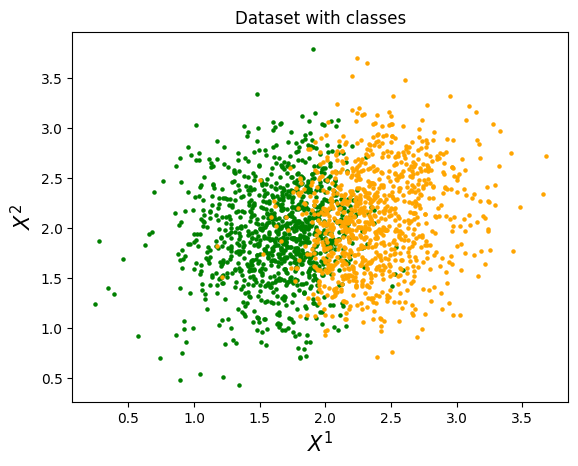

In [4]:
plt.title('Dataset with classes')
plt.scatter(X[Z==0,0],X[Z==0,1], s=5, color='green', label=r'$Z=0$')
plt.scatter(X[Z==1,0],X[Z==1,1], s=5, color='orange', label=r'$Z=1$')
plt.xlabel('$X^1$', fontsize=15)
plt.ylabel('$X^2$', fontsize=15)
plt.show()

## Simulation of the modified covariates and of the observed labels

In [5]:
F = 0.8 + 0.4*np.random.rand(2000)
Xe = X.copy()
Xe[:,0] *= F
Xe[:,1] *= F
phi = np.array([-10.,0.,4.5])
Y = Z * (np.random.rand(2000)<=scs.logistic.cdf(phi[0] + np.dot(Xe, phi[1:]))).astype(int)

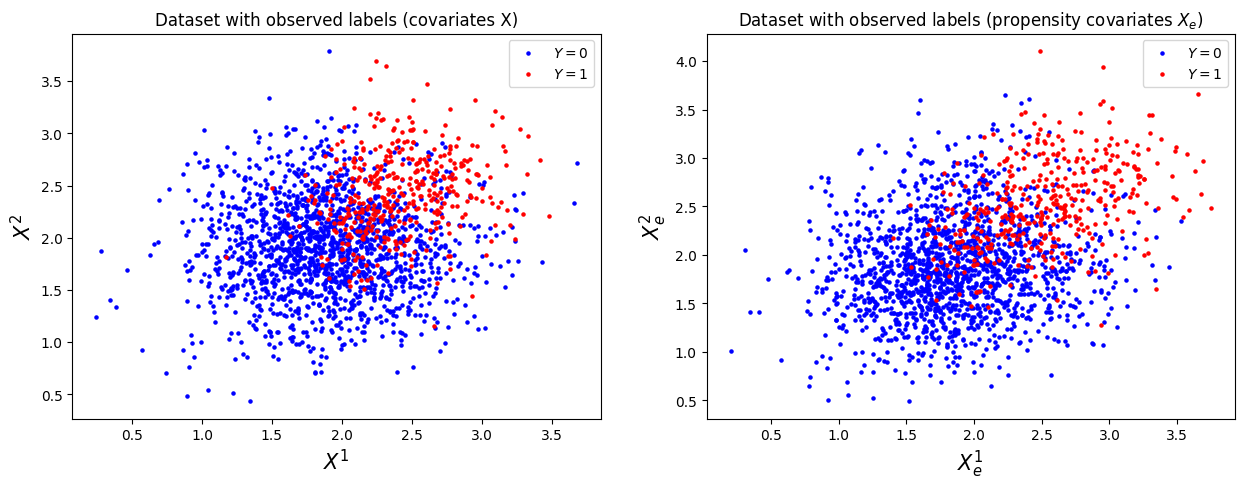

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].set_title('Dataset with observed labels (covariates X)')
axes[0].set_xlabel('$X^1$', fontsize=15)
axes[0].set_ylabel('$X^2$', fontsize=15)
axes[0].scatter(X[Y==0,0],X[Y==0,1], s=5, color='blue', label=r'$Y=0$')
axes[0].scatter(X[Y==1,0],X[Y==1,1], s=5, color='red', label=r'$Y=1$')

axes[1].set_title('Dataset with observed labels (propensity covariates $X_e$)')
axes[1].set_xlabel('$X_e^1$', fontsize=15)
axes[1].set_ylabel('$X_e^2$', fontsize=15)
axes[1].scatter(Xe[Y==0,0],Xe[Y==0,1], s=5, color='blue', label=r'$Y=0$')
axes[1].scatter(Xe[Y==1,0],Xe[Y==1,1], s=5, color='red', label=r'$Y=1$')

axes[0].legend()
axes[1].legend()
plt.show()

# Estimation of the model

The model is estimated by:
+ initializing an instance of `PUClassifier`: the arguments of the PU model are the classification model (here a logistic regression `LinearLogisticRegression`) and the propensity model (here a logistic propensity `LogisticPropensity`). Other classification and propensity models are available in modules `pysarpu.classification` and `pysarpu.propensity`.
+ calling `fit` method by passing as arguments the covariates $X$, the modified covariates $X_e$ and the observed labels $Y$. The parameter `n_init` represents the number of initializations to consider in the Small EM initialization strategy.

In [7]:
pu_model1 = PUClassifier(LinearLogisticRegression(), LogisticPropensity())

In [8]:
pu_model1.fit(X, Xe, Y, n_init=20)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


### Estimated parameters can be printed

In [9]:
pu_model1

PU classifier 
theta = [-15.65184116   8.52512355  -0.61060389]
phi = [-10.02979223  -0.08942313   4.63131681]

## Visualization of the results

In [10]:
xx = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
yy = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
x_, y_ = np.meshgrid(xx, yy)
xy_ = np.concatenate([x_[:,:,np.newaxis], y_[:,:,np.newaxis]], axis=2)
z_ = pu_model1.predict_cproba(xy_)

In [11]:
xxe = np.linspace(Xe[:,0].min()-0.5, Xe[:,0].max()+0.5, 100)
yye = np.linspace(Xe[:,1].min()-0.5, Xe[:,1].max()+0.5, 100)
xe_, ye_ = np.meshgrid(xxe, yye)
xye_ = np.concatenate([xe_[:,:,np.newaxis], ye_[:,:,np.newaxis]], axis=2)
ze_ = pu_model1.e(xye_)

### Visualization of the estimated classifier and propensity

We can check that the estimated classifier only depends on the first covariate and that the estimated propensity depends on the second. This is coherent with the simulation.

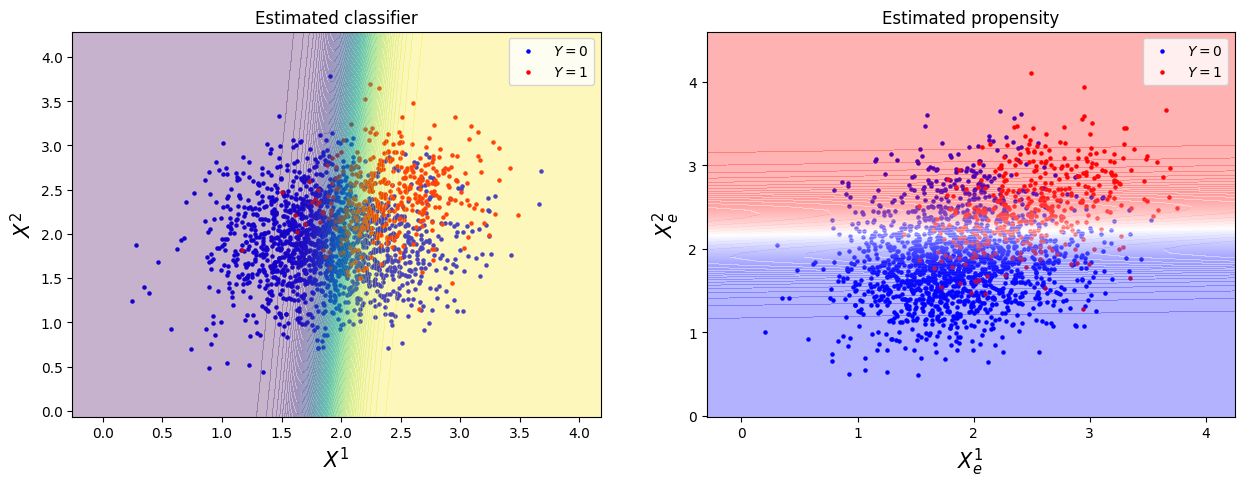

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].set_title('Estimated classifier')
axes[0].set_xlabel('$X^1$', fontsize=15)
axes[0].set_ylabel('$X^2$', fontsize=15)
axes[0].scatter(X[Y==0,0],X[Y==0,1], s=5, color='blue', label=r'$Y=0$')
axes[0].scatter(X[Y==1,0],X[Y==1,1], s=5, color='red', label=r'$Y=1$')
axes[0].contourf(x_, y_, z_, levels=100, alpha=0.3)

axes[1].set_title('Estimated propensity')
axes[1].set_xlabel('$X_e^1$', fontsize=15)
axes[1].set_ylabel('$X_e^2$', fontsize=15)
axes[1].scatter(Xe[Y==0,0],Xe[Y==0,1], s=5, color='blue', label=r'$Y=0$')
axes[1].scatter(Xe[Y==1,0],Xe[Y==1,1], s=5, color='red', label=r'$Y=1$')
axes[1].contourf(xe_, ye_, ze_, levels=100, alpha=0.3, cmap='bwr')

axes[0].legend()
axes[1].legend()
plt.show()

### Visualization of the estimated posterior probability

We represent on the left the classes ($Z$) posterior probabilities estimated, on the right the same thing with the probabilities on the labels ($Y$).

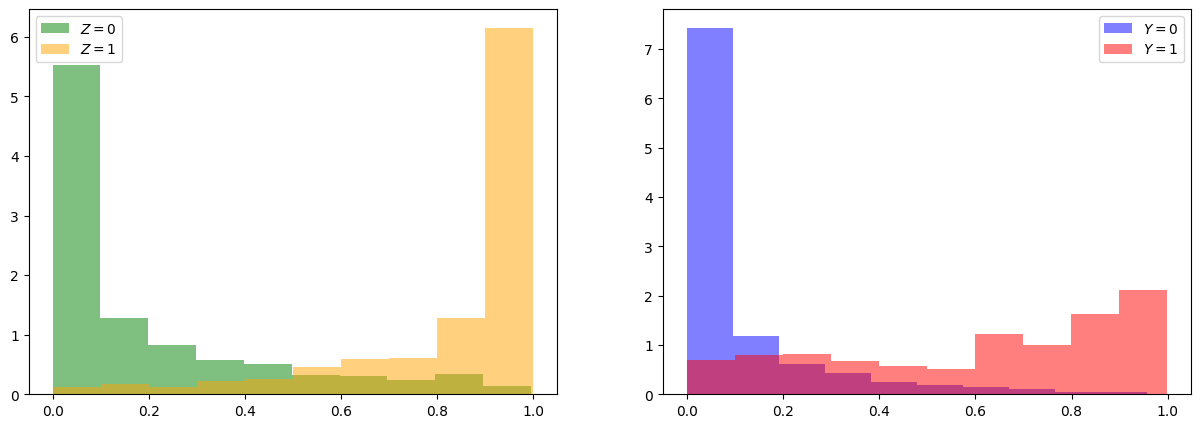

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].hist(pu_model1.predict_cproba(X)[Z==0], color='green', alpha=0.5, density=True, label=r'$Z=0$')
axes[0].hist(pu_model1.predict_cproba(X)[Z==1], color='orange', alpha=0.5, density=True, label=r'$Z=1$')
axes[1].hist(pu_model1.predict_proba(X, Xe)[Y==0], color='blue', alpha=0.5, density=True, label=r'$Y=0$')
axes[1].hist(pu_model1.predict_proba(X, Xe)[Y==1], color='red', alpha=0.5, density=True, label=r'$Y=1$')
axes[0].legend()
axes[1].legend()
plt.show()